In [1]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), ".."))
from collections import defaultdict

import numpy as np
import pandas as pd
from tqdm import tqdm
import postprocess_general_loader
import postprocess_randomness_loader
import postprocess_randomness_enhanced_loader
import src_py.feature
import matplotlib.pyplot as plt
import statistics
import randomness_analysis_loader
import math
import postprocess_selfdraw_loader
import copy
def default_value():
    return 0
def default_list():
    return []
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams["figure.figsize"] = (15,7)
plt.rcParams['font.size'] = (16)

In [3]:
## Verify Integrity of Game Postprocessing Results

dst = "../processed/"
err_ct = 0
dir_list = os.listdir(dst)
dir_len = len(dir_list)
pbar = tqdm(dir_list)
error_list = []
for file in pbar:
    (
        init_dist,
        play_count,
        play_to_shanten,
        winner_id,
        fan_list,
    ) = postprocess_general.load_from_result(dst, file)

    if len(init_dist) == 4:
        for i in init_dist:
            if i < 0 or i > 9:
                error_list.append(file)
                err_ct += 1
    else:
        err_ct += 1
        error_list.append(file)
    if len(play_count) == 4:
        for i in play_count:
            if i < 0:
                err_ct += 1
                error_list.append(file)
    else:
        err_ct += 1
        error_list.append(file)
    if len(play_to_shanten) == 4:
        for i in play_to_shanten:
            if i < 0:
                err_ct += 1
                error_list.append(file)
    else:
        err_ct += 1
        error_list.append(file)
    if winner_id not in [-1, 0, 1, 2, 3]:
        err_ct += 1
        error_list.append(file)

print("Integrity Check Done! {} files checked, {} error detected!".format(dir_len ,err_ct))
print(error_list)


100%|██████████| 98209/98209 [10:35<00:00, 154.54it/s]

Integrity Check Done! 98209 files checked, 0 error detected!
[]


In [2]:
## Initializing Data Holder Variables
init_dist_distri = defaultdict(default_value)
init_dist_diff_distri = defaultdict(default_value)
winner_init_dist_distri = defaultdict(default_value)
winner_relative_init_pos_gen = defaultdict(default_value)
winner_relative_init_pos_polar = defaultdict(default_value)
winner_relative_init_pos_iso = defaultdict(default_value) #位置赢
winner_relative_init_pos_iso_detail = defaultdict(default_value) #位置赢, 分开统计不同位置
winner_relative_init_pos_tot = defaultdict(default_value) #位置总和
winner_relative_init_pos_pc = defaultdict(default_value) #位置百分比
fan_type = defaultdict(default_value) #位置百分比
winner_id_distri = defaultdict(default_value)
play_efficiency = [] #牌效率，由上听玩家计算
shanten_to_win_wait_round = defaultdict(default_value) #上听后赢牌等待时间，由赢家计算
shanten_to_lose_wait_round = defaultdict(default_value) #上听后未赢牌等待时间，由上听但未赢玩家计算
play_count_distri = defaultdict(default_value) #统计上手数
winner_play_count_distri = defaultdict(default_value) #统计赢家上手数
play_to_shanten_distri = defaultdict(default_value)



In [3]:
## Analyzing Processed Results
cpuCount = os.cpu_count() // 2
path = "../data/"
dst = "../processed/"
dir_list = os.listdir(dst)
    
pbar = tqdm(dir_list)
for file in pbar:
    init_dist, play_count, play_to_shanten, winner_id, fan_list = postprocess_general.load_from_result(dst, file)

    for i in range(4):
        if play_to_shanten[i]!=99:
            play_to_shanten_distri[play_to_shanten[i]]+=1
            play_efficiency.append(1.0*play_to_shanten[i]/ max(init_dist[i],1))
            if i != winner_id:
                shanten_to_lose = play_count[i]-play_to_shanten[i]
                shanten_to_lose_wait_round[shanten_to_lose]+=1
        play_count_distri[play_count[i]]+=1
    winner_play_count_distri[play_count[winner_id]]+=1
        
    for fan in fan_list:
        fan_type[fan]+=1

    winner_id_distri[winner_id]+=1
    init_dist_sort_id = np.array(init_dist).argsort()
    max_init_dist = init_dist[init_dist_sort_id[3]]
    min_init_dist = init_dist[init_dist_sort_id[0]]
    init_dist_diff = max_init_dist-min_init_dist
    for dist in init_dist:
        init_dist_distri[dist]+=1
        relative_pos_tot = dist-min_init_dist
        winner_relative_init_pos_tot[relative_pos_tot]+=1
    
    
    init_dist_diff_distri[init_dist_diff]+=1
    if winner_id>=0 and winner_id<4:
        winner_init_dist_distri[init_dist[winner_id]]+=1
        shanten_to_win = play_count[winner_id]-play_to_shanten[winner_id]
        if shanten_to_win>=0:
            shanten_to_win_wait_round[shanten_to_win]+=1
        for i in range(len(init_dist_sort_id)):
            if winner_id==init_dist_sort_id[i]:
                winner_relative_init_pos_gen[i]+=1
                if init_dist_diff>=3:
                    winner_relative_init_pos_polar[i]+=1
                break
        relative_pos_iso = init_dist[winner_id]-min_init_dist 
        winner_relative_init_pos_iso[relative_pos_iso]+=1
        winner_relative_init_pos_iso_detail[str(relative_pos_iso)+'-'+str(winner_id)]+=1
    
    

100%|██████████| 98209/98209 [18:15<00:00, 89.68it/s] 


In [5]:
cpuCount = os.cpu_count() // 2
path = "../data/"
dst = "../processed/"
dir_list = os.listdir(dst)

(
        botzone_log,
        tileWall,
        pack,
        handWall,
        obsWall,
        remaining_tile,
        _,
        winner_id,
        wind,
        fan_sum,
        fan_list,
    ) = feature.load_log(path, '0.npy')

In [12]:
request = "Score -22 -22 66 -22"
t = request.split()
a = list(map(int, t[1:]))
a

[-22, -22, 66, -22]

## Data Analysis
### Initial Distance Distribution

Initial Distance Distribution of all players across 98209 games

In [115]:
winner_init_dist_distri_cp = copy.deepcopy(winner_init_dist_distri)
sum_of_rounds=0
for t in winner_init_dist_distri_cp:
    sum_of_rounds+=winner_init_dist_distri_cp[t]
for t in winner_init_dist_distri_cp:
    winner_init_dist_distri_cp[t] = 100.0*winner_init_dist_distri_cp[t]/sum_of_rounds
init_dist_distri_cp = copy.deepcopy(init_dist_distri)
sum_of_rounds=0
for t in init_dist_distri_cp:
    sum_of_rounds+=init_dist_distri_cp[t]
for t in init_dist_distri_cp:
    init_dist_distri_cp[t] = 100.0*init_dist_distri_cp[t]/sum_of_rounds

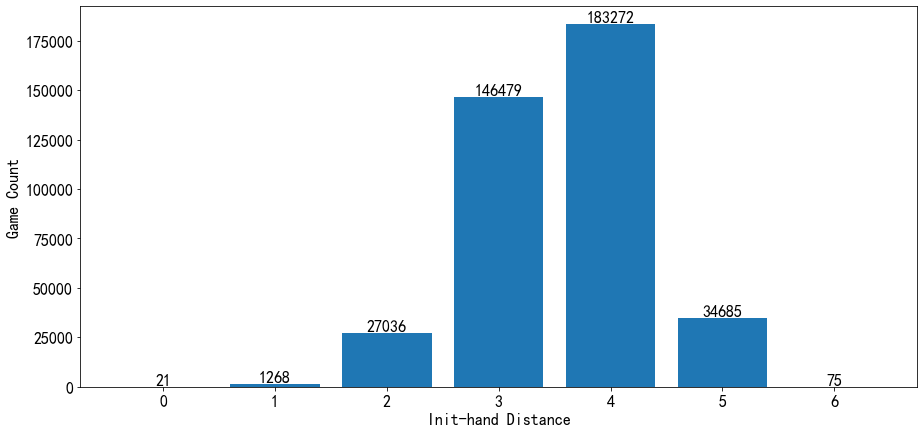

In [118]:
dists = list(init_dist_distri.keys())
values = list(init_dist_distri.values())
fig, ax = plt.subplots()
bars = ax.bar(dists, values, tick_label=dists)
ax.bar_label(bars)
plt.xlabel("Init-hand Distance")
plt.ylabel("Game Count")
plt.show()

### Winner's initial Distance Distribution

Winner's initial distribution across 98209 games

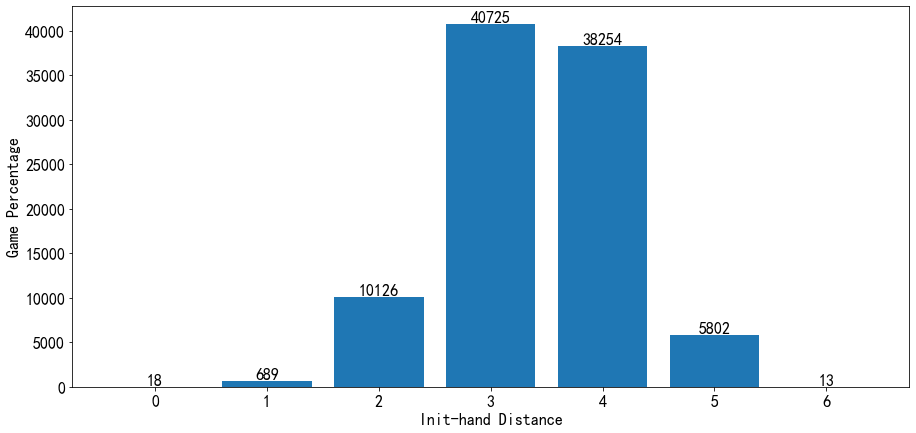

In [6]:
dists = list(winner_init_dist_distri.keys())
values = list(winner_init_dist_distri.values())
fig, ax = plt.subplots()
bars = ax.bar(dists, values, tick_label=dists)
ax.bar_label(bars)
plt.xlabel("Init-hand Distance")
plt.ylabel("Game Percentage")
plt.show()

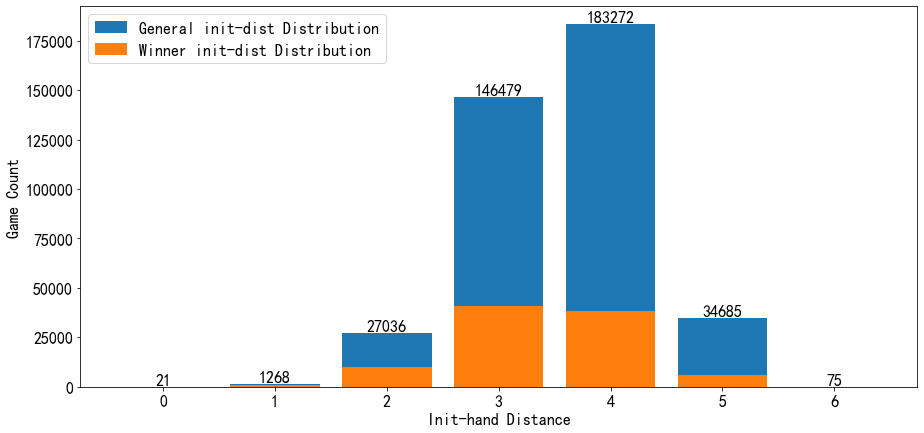

In [142]:
dists = list(init_dist_distri.keys())
values = list(init_dist_distri.values())
dist = list(winner_init_dist_distri.keys())
value = list(winner_init_dist_distri.values())
fig, ax = plt.subplots()
bars = ax.bar(dists, values, tick_label=dists, label = "General init-dist Distribution", alpha=1)
bar = ax.bar(dist, value, label = "Winner init-dist Distribution", alpha=1)
ax.bar_label(bars)
plt.xlabel("Init-hand Distance")
plt.ylabel("Game Count")
plt.legend()
plt.show()

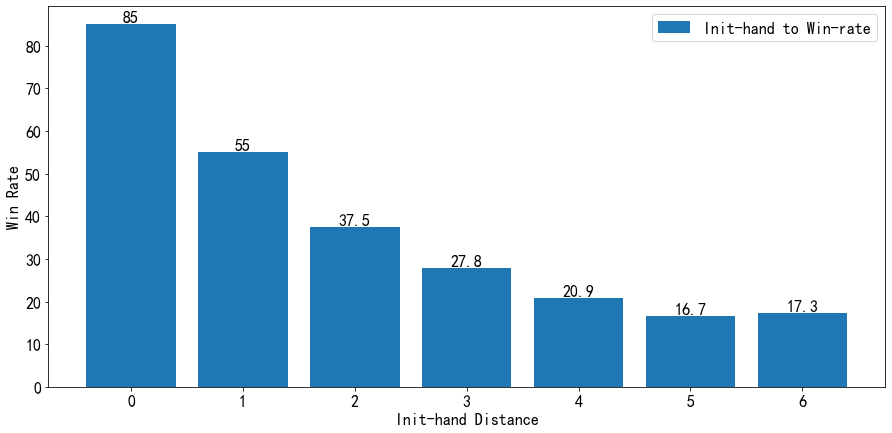

In [8]:
dists = [0,1,2,3,4,5,6]
values = [85, 55, 37.5, 27.8, 20.9, 16.7, 17.3]
fig, ax = plt.subplots()
bars = ax.bar(dists, values, tick_label=dists, label = "Init-hand to Win-rate", alpha=1)
ax.bar_label(bars)
plt.xlabel("Init-hand Distance")
plt.ylabel("Win Rate")
plt.legend()
plt.show()

#### Init-dist to Win-chance Mapping
0. 天胡：100%；
1. 0上听：~85%; 
2. 1上听：~55%; 
3. 2上听：~37.4%; 
4. 3上听：~27.8%; 
5. 4上听：~20.9%; 
6. 5上听：~16.7%; 
7. 6上听及以上：~0%；

每一档到下一档，胡牌概率 *0.65-0.75

### Initial Distance Difference Distribution

Max difference between players' initial distribution across 98209 games

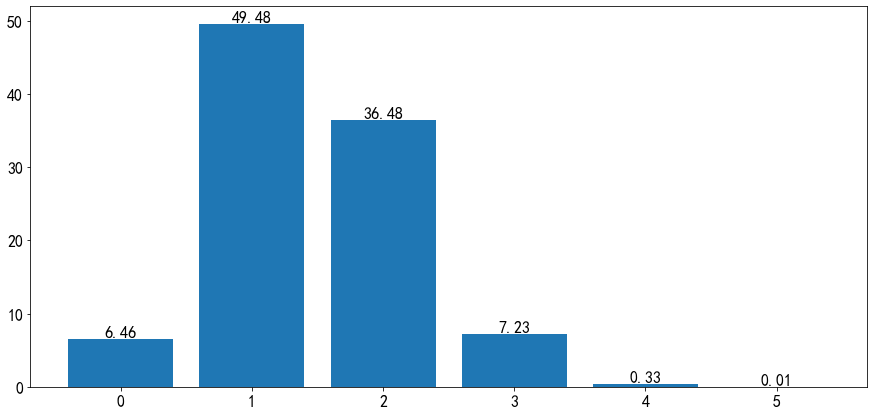

In [4]:
total_val = sum(init_dist_diff_distri.values())
for d in init_dist_diff_distri:
    init_dist_diff_distri[d]=100.0*init_dist_diff_distri[d]/total_val
dists = list(init_dist_diff_distri.keys())
values = list(init_dist_diff_distri.values())

fig, ax = plt.subplots()
bars = ax.bar(dists, values, tick_label=dists)
ax.bar_label(bars, fmt="%.2f")
plt.show()

### Winner's Precedence Distribution

Winner's Seat Position Distribution

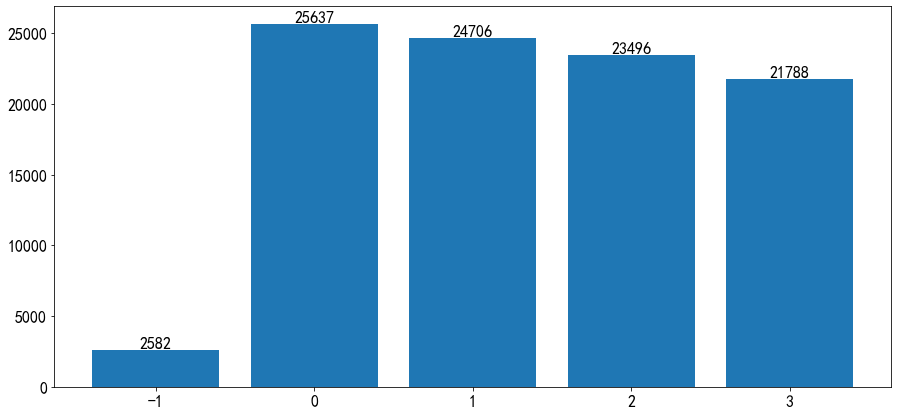

In [122]:
dists = list(winner_id_distri.keys())
values = list(winner_id_distri.values())
fig, ax = plt.subplots()
bars = ax.bar(dists, values, tick_label=dists)
ax.bar_label(bars)
plt.show()

### Winner's Relative Initial Distance Position

Winner's relative Initial Distance Ranking Among 4 players, when distances between two or more players equal, break equality with players' precedence.

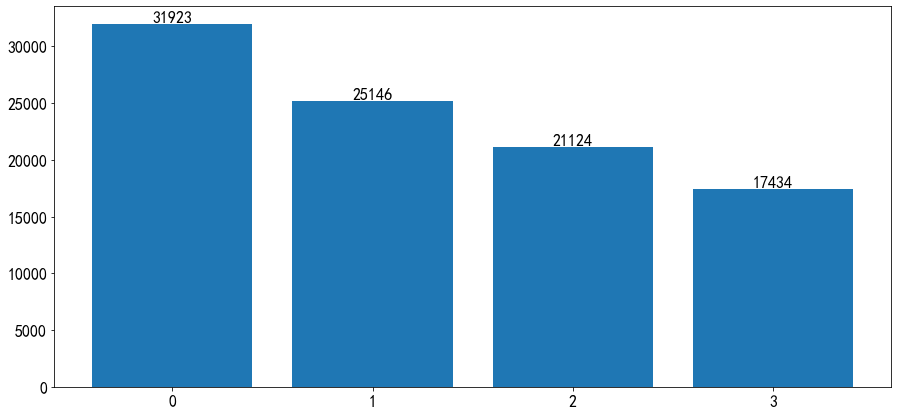

In [123]:
dists = list(winner_relative_init_pos_gen.keys())
values = list(winner_relative_init_pos_gen.values())
fig, ax = plt.subplots()
bars = ax.bar(dists, values, tick_label=dists)
ax.bar_label(bars)
plt.show()

### Winner's Relative Initial Distance 

相对优势（赢家初始上听数-最小初始上听数）的胜率百分比；0：距离最小上听数为0； 5： 距离最小上听数为5

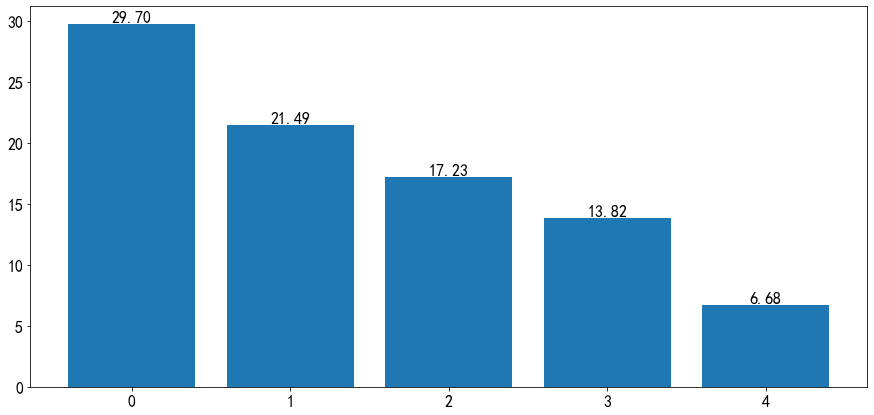

In [5]:
for k in winner_relative_init_pos_tot:
    winner_relative_init_pos_pc[k]=100*winner_relative_init_pos_iso[k]/winner_relative_init_pos_tot[k]
del winner_relative_init_pos_pc[5]
dists = list(winner_relative_init_pos_pc.keys())
values = list(winner_relative_init_pos_pc.values())
fig, ax = plt.subplots()
bars = ax.bar(dists, values, tick_label=dists)
ax.bar_label(bars, fmt = "%.2f")
# plt.bar(dists, values, tick_label=dists, label=values)
# print(winner_relative_init_pos_polar)
plt.show()

In [127]:
winner_relative_init_pos_pc_list = []
for i in range(1,5):
    winner_relative_init_pos_pc_tmp  = defaultdict(default_value)
    for k in winner_relative_init_pos_tot:
        sum=0
        for j in range(i):
            sum+=winner_relative_init_pos_iso_detail[str(k)+'-'+str(j)]

        winner_relative_init_pos_pc_tmp[k]=sum/winner_relative_init_pos_tot[k]
    del winner_relative_init_pos_pc_tmp[5]
    winner_relative_init_pos_pc_list.append(winner_relative_init_pos_pc_tmp)

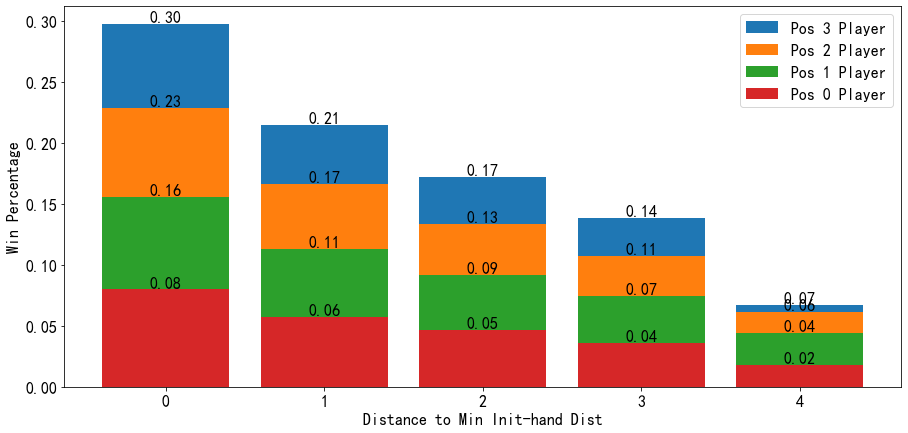

In [128]:
dist0 = list(winner_relative_init_pos_pc_list[0].keys())
value0 = list(winner_relative_init_pos_pc_list[0].values())
dist1 = list(winner_relative_init_pos_pc_list[1].keys())
value1 = list(winner_relative_init_pos_pc_list[1].values())
dist2 = list(winner_relative_init_pos_pc_list[2].keys())
value2 = list(winner_relative_init_pos_pc_list[2].values())
dist3 = list(winner_relative_init_pos_pc_list[3].keys())
value3 = list(winner_relative_init_pos_pc_list[3].values())
fig, ax = plt.subplots()
bar3 = ax.bar(dist3, value3, label = "Pos 3 Player")
bar2 = ax.bar(dist2, value2,  label = "Pos 2 Player")
bar1 = ax.bar(dist1, value1, label = "Pos 1 Player")
bar0 = ax.bar(dist0, value0, tick_label=dist0, label = "Pos 0 Player")



ax.bar_label(bar3, fmt='%.2f')
ax.bar_label(bar2, fmt='%.2f')
ax.bar_label(bar1, fmt='%.2f')
ax.bar_label(bar0, fmt='%.2f')
# plt.bar(dists, values, tick_label=dists, label=values)
# print(winner_relative_init_pos_polar)
plt.xlabel("Distance to Min Init-hand Dist")
plt.ylabel("Win Percentage")
plt.legend()
plt.show()

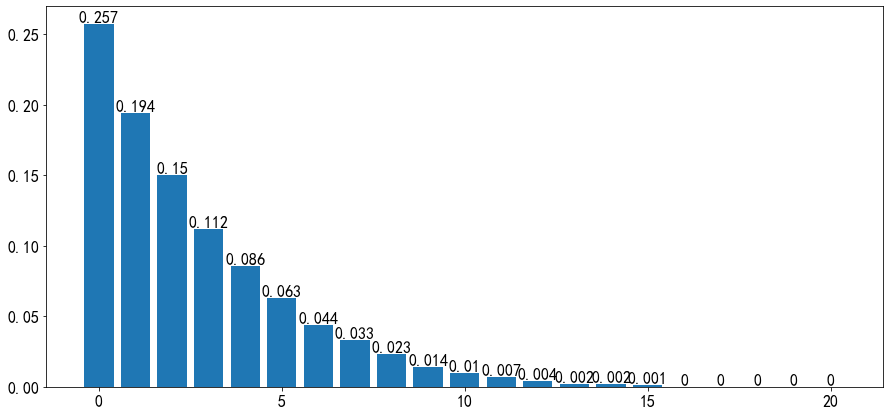

In [129]:
total_entry = 0
for k in shanten_to_win_wait_round:
    total_entry+=shanten_to_win_wait_round[k]
for k in shanten_to_win_wait_round:
    shanten_to_win_wait_round[k] = round(1.0* shanten_to_win_wait_round[k]/total_entry,3)
dists = list(shanten_to_win_wait_round.keys())
values = list(shanten_to_win_wait_round.values())
fig, ax = plt.subplots()
bars = ax.bar(dists, values)
ax.bar_label(bars)
# plt.bar(dists, values, tick_label=dists, label=values)
# print(winner_relative_init_pos_polar)
plt.show()

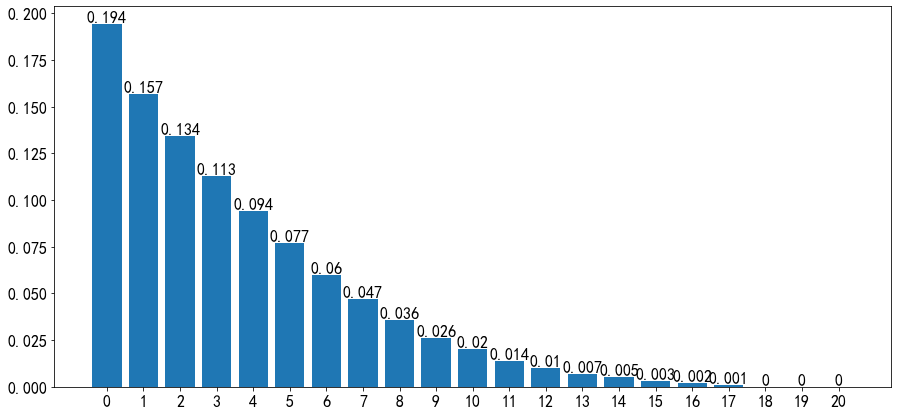

In [130]:
total_entry = 0
for k in shanten_to_lose_wait_round:
    total_entry+=shanten_to_lose_wait_round[k]
for k in shanten_to_lose_wait_round:
    shanten_to_lose_wait_round[k] = round(1.0* shanten_to_lose_wait_round[k]/total_entry,3)
dists = list(shanten_to_lose_wait_round.keys())
values = list(shanten_to_lose_wait_round.values())
fig, ax = plt.subplots()
bars = ax.bar(dists, values, tick_label=dists)
ax.bar_label(bars)
# plt.bar(dists, values, tick_label=dists, label=values)
# print(winner_relative_init_pos_polar)
plt.show()

### Analysis On Play Count 上手数分析

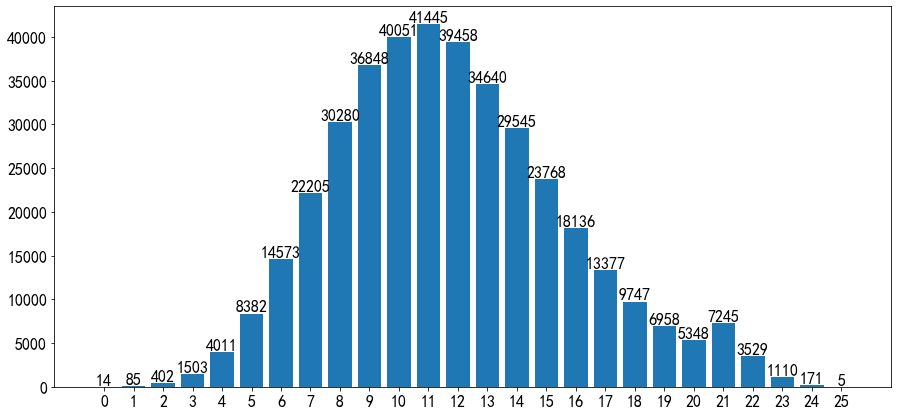

In [6]:
dists = list(play_count_distri.keys())
values = list(play_count_distri.values())
fig, ax = plt.subplots()
bars = ax.bar(dists, values, tick_label=dists)
ax.bar_label(bars)
# plt.bar(dists, values, tick_label=dists, label=values)
# print(winner_relative_init_pos_polar)
plt.show()

In [7]:
play_to_shanten_distri_cp = copy.deepcopy(play_to_shanten_distri)
sum_of_rounds=0
for t in play_to_shanten_distri_cp:
    sum_of_rounds+=play_to_shanten_distri_cp[t]
for t in play_to_shanten_distri_cp:
    play_to_shanten_distri_cp[t] = 100.0*play_to_shanten_distri_cp[t]/sum_of_rounds
winner_play_count_distri_cp = copy.deepcopy(winner_play_count_distri)
sum_of_rounds=0
for t in winner_play_count_distri_cp:
    sum_of_rounds+=winner_play_count_distri_cp[t]
for t in winner_play_count_distri_cp:
    winner_play_count_distri_cp[t] = 100.0*winner_play_count_distri_cp[t]/sum_of_rounds

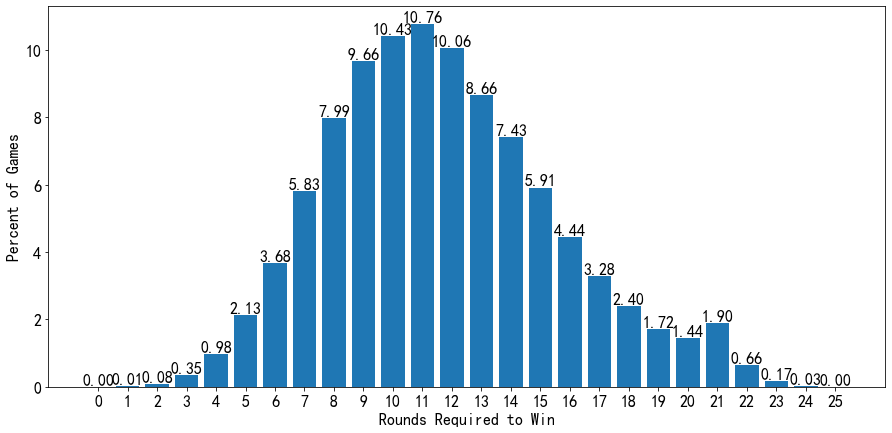

In [8]:
dists = list(winner_play_count_distri_cp.keys())
values = list(winner_play_count_distri_cp.values())
fig, ax = plt.subplots()
bars = ax.bar(dists, values, tick_label=dists)
ax.bar_label(bars, fmt='%.2f')
# plt.bar(dists, values, tick_label=dists, label=values)
# print(winner_relative_init_pos_polar)
plt.xlabel("Rounds Required to Win")
plt.ylabel("Percent of Games")
plt.show()

### 上听数所需局数

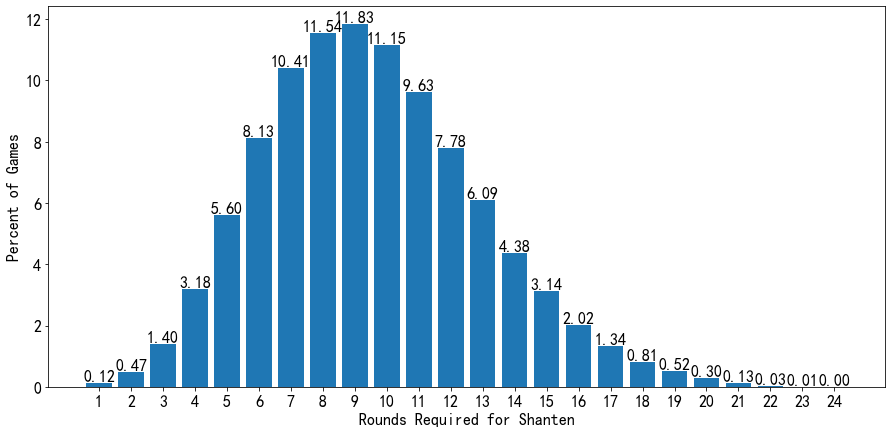

In [9]:
dists = list(play_to_shanten_distri_cp.keys())
values = list(play_to_shanten_distri_cp.values())
fig, ax = plt.subplots()
bars = ax.bar(dists, values, tick_label=dists)
ax.bar_label(bars, fmt='%.2f')
# plt.bar(dists, values, tick_label=dists, label=values)
# print(winner_relative_init_pos_polar)
plt.xlabel("Rounds Required for Shanten")
plt.ylabel("Percent of Games")
plt.show()

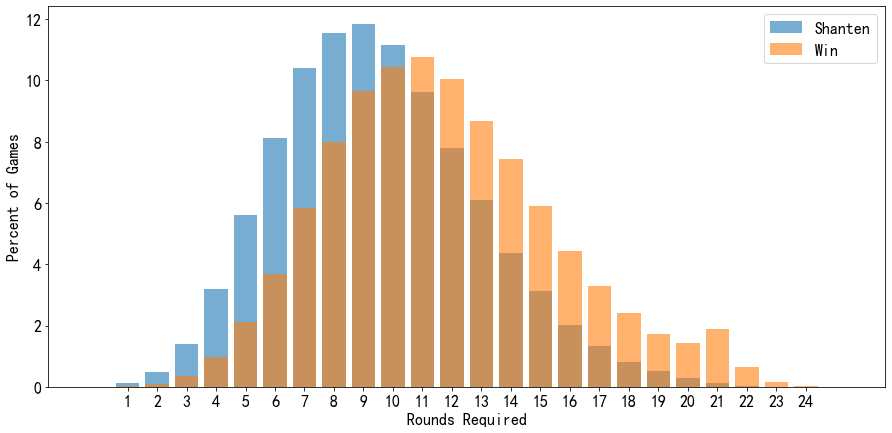

In [136]:
dists = list(play_to_shanten_distri_cp.keys())
values = list(play_to_shanten_distri_cp.values())
dist = list(winner_play_count_distri_cp.keys())
value = list(winner_play_count_distri_cp.values())
fig, ax = plt.subplots()
bars = ax.bar(dists, values, tick_label=dists, label = "Shanten", alpha=0.6)
bar = ax.bar(dist, value, label = "Win", alpha=0.6)
# plt.bar(dists, values, tick_label=dists, label=values)
# print(winner_relative_init_pos_polar)
plt.xlabel("Rounds Required")
plt.ylabel("Percent of Games")
plt.legend()
plt.show()

### Summary 总结

平均初始上听数：3

中位数上手数（强AI）：11

牌效率：3.2上手/上手数减一

上听后2手内胡牌概率>50%

### Analysis on Random hand-wall Initialization 对抹除初始手牌随机性的分析

方法：从98000局中，随机挑选10000局，随机决定4位的玩家座位，统计累计起始手牌数。找到最早的一局，使得之后的起始手牌累计差异不超过5%、10%。

### 研究初始手牌，最终手牌，以及打牌路径

In [3]:
## Verify Integrity of Game Postprocessing_alt Results
path = "../data"
dst = "../processed_alt/"
missing_list = []
data_list = os.listdir(path)
dir_list = os.listdir(dst)
dir_len = len(dir_list)
for i in data_list:
    if i not in dir_list:
        missing_list.append(i)
print(missing_list)

[]


In [2]:
## Analyzing Processed Results
path = "../data/"
dst = "../processed_alt/"
dir_list = os.listdir(dst)
global_total = 0
global_retro_fit = 0
winner_total = 0
winner_retro_fit = 0
    
pbar = tqdm(dir_list)
for file in pbar:
    init_dist,init_list_tier, final_retro_dist, final_list_tier, intersection_related, winner_id = postprocess_alt.load_from_result_alt(dst, file)
    global_total+=len(intersection_related)
    global_retro_fit+=sum(intersection_related)
    if winner_id>=0 and winner_id<4:
        winner_total+=1
        winner_retro_fit+=intersection_related[winner_id]

print('整体情况：终局时手牌组合为初始最优组合的概率为：{}'.format(1.0*global_retro_fit/global_total*100))
print('赢家情况：终局时手牌组合为初始最优组合的概率为：{}'.format(1.0*winner_retro_fit/winner_total*100))



100%|██████████| 98209/98209 [05:39<00:00, 289.32it/s]

0.15890091539471943
0.16377173810743828


In [ ]:
## Analyzing Processed Results
path = "../data/"
dst = "../processed_alt/"
dir_list = os.listdir(dst)
retention_dict = defaultdict(default_list)
tiles_from_others_dict = defaultdict(default_list)

pbar = tqdm(dir_list)
for file in pbar:
    (init_dist,  # 1
        init_list_tier,  # 2
        final_retro_dist,  # 3
        final_list_tier,  # 4
        consistent_tile_count,  # 5
        tiles_from_others,
        intersection_related,  # 6
        winner_id) = postprocess_randomness.load_from_result_alt(dst, file)
    for i in range(4):
        retention_dict[init_dist[i]].append(consistent_tile_count[i])
        tiles_from_others_dict[init_dist[i]].append(tiles_from_others[i])

In [38]:
## Analyzing Processed Results FOR WINNER
path = "../data/"
dst = "../processed_alt/"
dir_list = os.listdir(dst)
retention_dict = defaultdict(default_list)
tiles_from_others_dict = defaultdict(default_list)

pbar = tqdm(dir_list)
for file in pbar:
    (init_dist,  # 1
        init_list_tier,  # 2
        final_retro_dist,  # 3
        final_list_tier,  # 4
        consistent_tile_count,  # 5
        tiles_from_others,
        intersection_related,  # 6
        winner_id) = postprocess_randomness.load_from_result_alt(dst, file)
    if winner_id >=0 and winner_id <=3:
        retention_dict[init_dist[winner_id]].append(consistent_tile_count[winner_id])
        tiles_from_others_dict[init_dist[winner_id]].append(tiles_from_others[winner_id])

100%|██████████| 98209/98209 [19:00<00:00, 86.14it/s]


In [39]:
plot_dict = {}
changed_tiles = {}
plot_tfo_dict = {}
plot_selfdrawn_dict = {}
for k in range(7):
    avg=sum(retention_dict[k])/len(retention_dict[k])
    tfo_avg = sum(tiles_from_others_dict[k])/len(tiles_from_others_dict[k])

    plot_tfo_dict[k-1]=tfo_avg
    plot_dict[k-1]=avg
    
    changed_tile = 14-k-avg
    changed_tiles[k-1]=changed_tile
    plot_selfdrawn_dict[k-1]=14-avg-tfo_avg - changed_tile
    print("Avg retention tiles for initial dist {} is {:.2f}, deviated from the initial by {:.2f}, got {:.2f} from others ({:.2f}%).".format(k-1,avg, 14-k-avg, tfo_avg, tfo_avg/(14.000001-avg)*100))

Avg retention tiles for initial dist -1 is 14.00, deviated from the initial by 0.00, got 0.00 from others (0.00%).
Avg retention tiles for initial dist 0 is 12.45, deviated from the initial by 0.55, got 0.19 from others (12.06%).
Avg retention tiles for initial dist 1 is 10.95, deviated from the initial by 1.05, got 0.83 from others (27.07%).
Avg retention tiles for initial dist 2 is 9.71, deviated from the initial by 1.29, got 1.17 from others (27.35%).
Avg retention tiles for initial dist 3 is 8.73, deviated from the initial by 1.27, got 1.33 from others (25.30%).
Avg retention tiles for initial dist 4 is 7.89, deviated from the initial by 1.11, got 1.32 from others (21.68%).
Avg retention tiles for initial dist 5 is 7.03, deviated from the initial by 0.97, got 1.30 from others (18.67%).


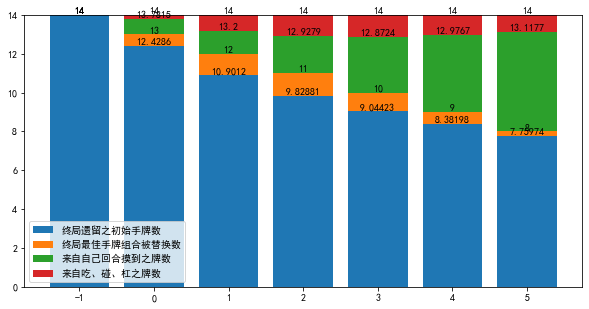

In [41]:
dists = list(plot_dict.keys())
values = list(plot_dict.values())
tile_ct = list(changed_tiles.values())
tile_selfdrawn = list(plot_selfdrawn_dict.values())
tile_from_other = list(plot_tfo_dict.values())
fig, ax = plt.subplots()
bars = ax.bar(dists, values, tick_label=dists,label = '终局遗留之初始手牌数')
bar = ax.bar(dists, tile_ct, bottom = values,label = '终局最佳手牌组合被替换数')
ba = ax.bar(dists, tile_selfdrawn, bottom = np.sum([values, tile_ct], axis=0).tolist() ,label = '来自自己回合摸到之牌数')
b= ax.bar(dists, tile_from_other, bottom = np.sum([values, tile_ct, tile_selfdrawn], axis=0).tolist() ,label = '来自吃、碰、杠之牌数')
ax.bar_label(bars)
ax.bar_label(bar)
ax.bar_label(ba)
ax.bar_label(b)
# plt.bar(dists, values, tick_label=dists, label=values)
# print(winner_relative_init_pos_polar)
plt.legend()
plt.show()

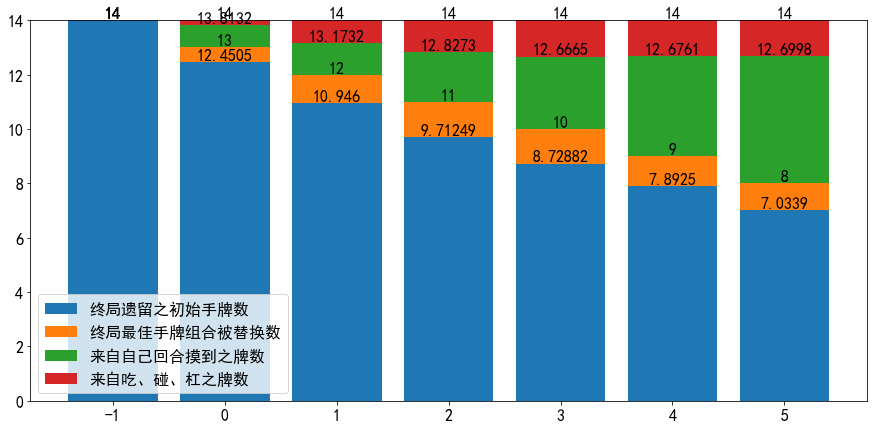

In [40]:
dists = list(plot_dict.keys())
values = list(plot_dict.values())
tile_ct = list(changed_tiles.values())
tile_selfdrawn = list(plot_selfdrawn_dict.values())
tile_from_other = list(plot_tfo_dict.values())
fig, ax = plt.subplots()
bars = ax.bar(dists, values, tick_label=dists,label = '终局遗留之初始手牌数')
bar = ax.bar(dists, tile_ct, bottom = values,label = '终局最佳手牌组合被替换数')
ba = ax.bar(dists, tile_selfdrawn, bottom = np.sum([values, tile_ct], axis=0).tolist() ,label = '来自自己回合摸到之牌数')
b= ax.bar(dists, tile_from_other, bottom = np.sum([values, tile_ct, tile_selfdrawn], axis=0).tolist() ,label = '来自吃、碰、杠之牌数')
ax.bar_label(bars)
ax.bar_label(bar)
ax.bar_label(ba)
ax.bar_label(b)
# plt.bar(dists, values, tick_label=dists, label=values)
# print(winner_relative_init_pos_polar)
plt.legend()
plt.show()

In [9]:
path = "../data/"
dst = "../processed_alt/"
dir_list = os.listdir(dst)
src_list = os.listdir(path)
pbar = tqdm(src_list)
problem_list=[]
for file in pbar:
    if file not in dir_list:
        problem_list.append(file)

100%|██████████| 98209/98209 [00:43<00:00, 2261.03it/s] 


In [10]:
## Analyzing shanten and hu
path = "../data/"
dst = "../processed_enhanced/"
dir_list = os.listdir(dst)
self_shanten_dict = defaultdict(default_value)
self_hu_dict = defaultdict(default_value)
init_dist_to_shanten_dict = defaultdict(default_list)
init_dist_to_hu_dict = defaultdict(default_list)
winner_init_dist = []
winner_dist_to_shanten = []
winner_dist_to_hu = []

pbar = tqdm(dir_list)
for file in pbar:
    (init_dist,  # 1
    init_hand_hash,  # 2
    init_min_dist_hash,  # 3
    final_min_dist_hash,  # 4
    consistent_tile_count,  # 5
    others_tile_count,  # 6
    first_shanten,  # 8
    first_hu,  # 9
    winner_id) = postprocess_selfdraw_loader.load_from_result_selfdraw(dst, file)
    for i in range(4):
        self_shanten_dict[first_shanten[i]]+=1
        self_hu_dict[first_hu[i]]+=1
        i_dist = init_dist[i]
        init_dist_to_shanten_dict[i_dist].append(first_shanten[i])
        init_dist_to_hu_dict[i_dist].append(first_hu[i])
    if winner_id>=0 and winner_id<=3:
        winner_init_dist.append(init_dist[winner_id])
        winner_dist_to_shanten.append(first_shanten[winner_id])
        winner_dist_to_hu.append(first_hu[winner_id])

100%|██████████| 98209/98209 [22:31<00:00, 72.68it/s]


In [11]:
self_shanten_dict[34] = self_shanten_dict[99]
del self_shanten_dict[99]
self_hu_dict[34] = self_hu_dict[99]
del self_hu_dict[99]

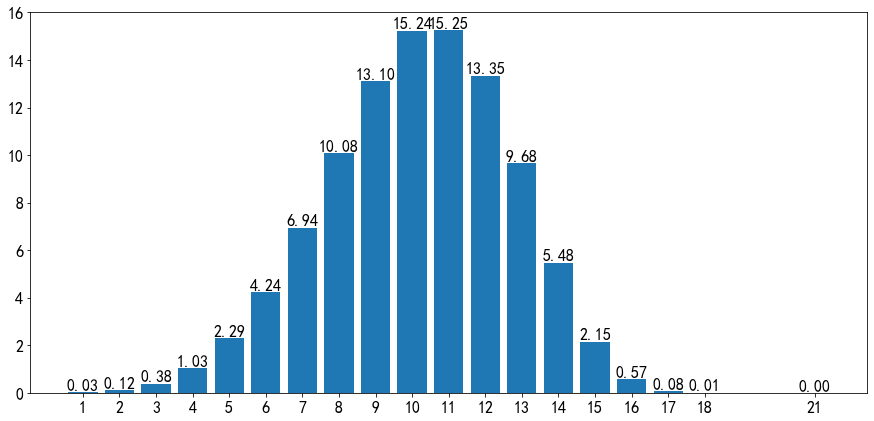

In [13]:
total_val = sum(self_shanten_dict.values())
for d in self_shanten_dict:
    self_shanten_dict[d] = 100.*self_shanten_dict[d]/total_val

dists = list(self_shanten_dict.keys())
values = list(self_shanten_dict.values())
dists_adj = [dist-13 for dist in dists]
fig, ax = plt.subplots()
bars = ax.bar(dists_adj, values, tick_label=dists_adj)
ax.bar_label(bars, fmt = "%.2f")
# plt.bar(dists, values, tick_label=dists, label=values)
# print(winner_relative_init_pos_polar)
plt.show()

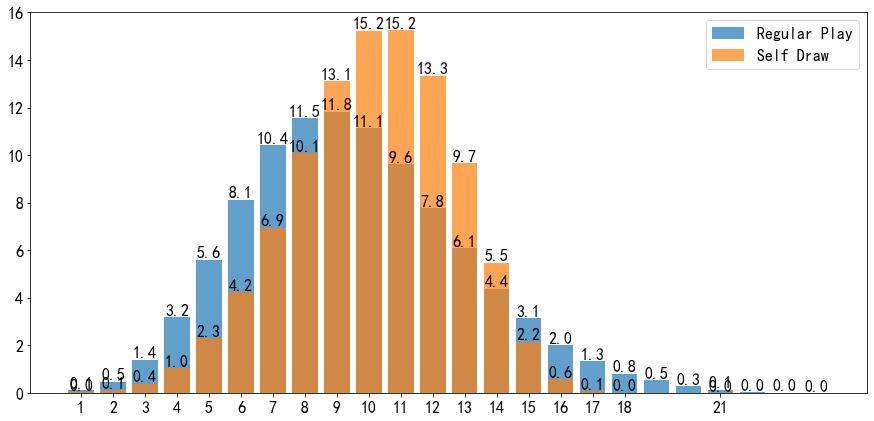

In [31]:
dists = list(self_shanten_dict.keys())
values = list(self_shanten_dict.values())
dist2 = list(play_to_shanten_distri_cp.keys())
value2 = list(play_to_shanten_distri_cp.values())
fig, ax = plt.subplots()
bar2 = ax.bar(dist2, value2, tick_label=dist2, label = "Regular Play", alpha = 0.7)
ax.bar_label(bar2, fmt='%.1f')
dists_adj = [dist-13 for dist in dists]
bars = ax.bar(dists_adj, values, tick_label=dists_adj, label = "Self Draw", alpha = 0.7)
ax.bar_label(bars, fmt = "%.1f")
# plt.bar(dists, values, tick_label=dists, label=values)
# print(winner_relative_init_pos_polar)
plt.legend()
plt.show()

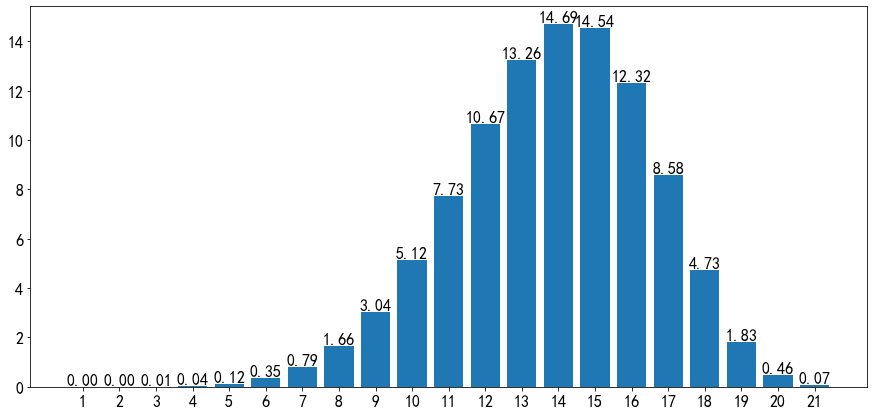

In [15]:

total_val = sum(self_hu_dict.values())
for d in self_hu_dict:
    self_hu_dict[d] = 100.*self_hu_dict[d]/total_val
dists = list(self_hu_dict.keys())
values = list(self_hu_dict.values())
dists_adj = [dist-13 for dist in dists]
fig, ax = plt.subplots()
bars = ax.bar(dists_adj, values, tick_label=dists_adj)
ax.bar_label(bars, fmt="%.2f")
# plt.bar(dists, values, tick_label=dists, label=values)
# print(winner_relative_init_pos_polar)
plt.show()

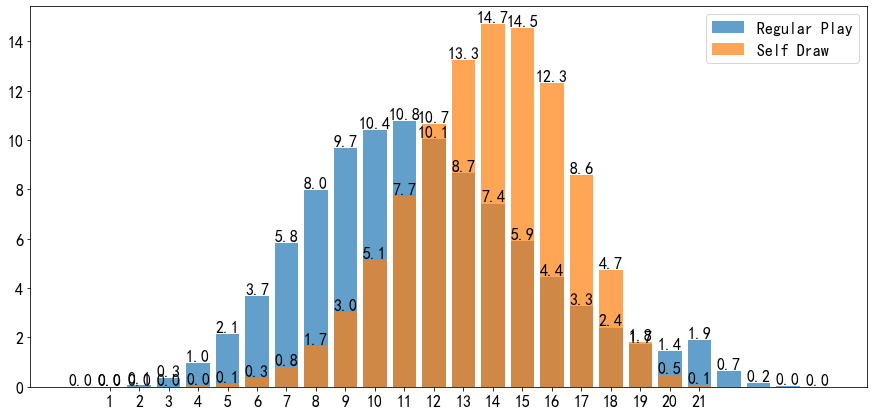

In [36]:
dists = list(self_hu_dict.keys())
values = list(self_hu_dict.values())
dist2 = list(winner_play_count_distri_cp.keys())
value2 = list(winner_play_count_distri_cp.values())
dists_adj = [dist-13 for dist in dists]
fig, ax = plt.subplots()

bar2 = ax.bar(dist2, value2, tick_label=dist2, alpha = 0.7, label = "Regular Play")
bars = ax.bar(dists_adj, values, tick_label=dists_adj, alpha = 0.7, label = "Self Draw")
ax.bar_label(bars, fmt="%.1f")
ax.bar_label(bar2, fmt="%.1f")
# plt.bar(dists, values, tick_label=dists, label=values)
# print(winner_relative_init_pos_polar)
plt.legend()
plt.show()

In [108]:
# init_dist_to_shanten_dict
dists=[]
mean_l = []
first_quantile_l = []
third_quantile_l = []
std_l = []
for d in init_dist_to_shanten_dict:
    if d<=6:
        raw = init_dist_to_shanten_dict[d].copy()
        
        raw.sort()
        legal_length = 0
        try:
            legal_length = raw.index(99)
        except:
            legal_length = len(raw)
        if len(raw)<=1:
            std = 0
        else:
            std = statistics.stdev(raw[:legal_length])

        dists.append(d)
        mean = 1.*sum(raw[:legal_length])/legal_length
        if d==0:
            mean_l.append(0)
            std_l.append(0)
            first_quantile_l.append(0)
            third_quantile_l.append(0)
        else:
            mean_l.append(mean-13)
            std_l.append(std)
            first_quantile_l.append(raw[int(len(raw)/4)]-13)
            third_quantile_l.append(raw[int(3*len(raw)/4)]-13)

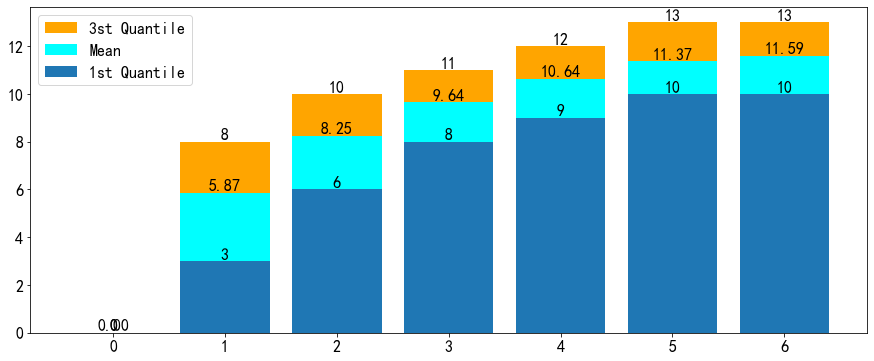

In [110]:
fig, ax = plt.subplots()

bar3 = ax.bar(dists, third_quantile_l, label = '3st Quantile', color = "orange")
bars = ax.bar(dists, mean_l, tick_label=dists, label = "Mean", color = "cyan")
bar1 = ax.bar(dists, first_quantile_l, label = '1st Quantile')
ax.bar_label(bars, fmt="%.2f")
ax.bar_label(bar1)
ax.bar_label(bar3)
# plt.suptitle('初始上听数 vs 自摸上听手数')
plt.legend()
plt.show()

In [102]:
# init_dist_to_hu_dict
dists=[]
mean_l = []
std_l = []
first_quantile_l = []
third_quantile_l = []
for d in init_dist_to_hu_dict:
    if d<=6:
        raw = init_dist_to_hu_dict[d].copy()
        
        raw.sort()
        legal_length = 0
        try:
            legal_length = raw.index(99)
        except:
            legal_length = len(raw)
        if len(raw)<=1:
            std = 0
        else:
            std = statistics.stdev(raw[:legal_length])
        dists.append(d)
        # if d==0:
        #     mean_l.append(1)
        #     std_l.append(0)
        # else:
        mean = 1.*sum(raw[:legal_length])/legal_length
        mean_l.append(mean-13)
        std_l.append(std)
        first_quantile_l.append(raw[int(legal_length/4)]-13)
        third_quantile_l.append(raw[int(3*legal_length/4)]-13)

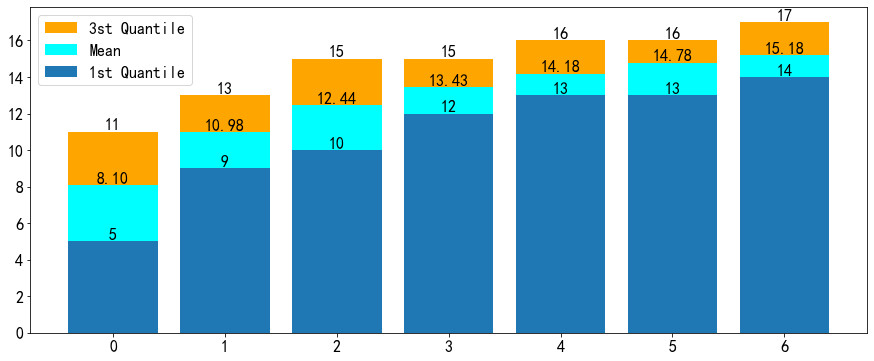

In [106]:
fig, ax = plt.subplots()
bar3 = ax.bar(dists, third_quantile_l, label = '3st Quantile', color = "orange")
bars = ax.bar(dists, mean_l, tick_label=dists, label = "Mean", color = "cyan")
bar1 = ax.bar(dists, first_quantile_l, label = '1st Quantile')
ax.bar_label(bars, fmt="%.2f")
ax.bar_label(bar1)
ax.bar_label(bar3)
# plt.bar(dists, values, tick_label=dists, label=values)
# print(winner_relative_init_pos_polar)
# plt.suptitle('初始上听数 vs 自摸胡牌手数')
plt.legend()
plt.show()

In [138]:
# init_dist_to_hu_dict
dists=[]
pct_l = []
for d in init_dist_to_hu_dict:
    if d<=6:
        raw = init_dist_to_hu_dict[d].copy()
        
        raw.sort()
        legal_length = 0
        try:
            legal_length = raw.index(99)
        except:
            legal_length = len(raw)
        dists.append(d)
        unable_to_finish_ct = len(raw)-legal_length
        pct_l.append(unable_to_finish_ct/legal_length*100)

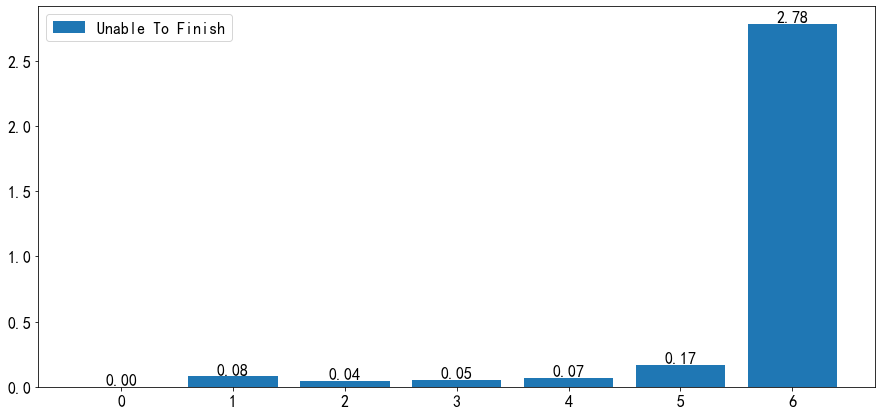

In [139]:
fig, ax = plt.subplots()
bars = ax.bar(dists, pct_l, tick_label=dists, label="Unable To Finish")
ax.bar_label(bars, fmt="%.2f")
# plt.bar(dists, values, tick_label=dists, label=values)
# print(winner_relative_init_pos_polar)
# plt.suptitle('初始上听数 vs 自摸胡牌手数')
plt.legend()
plt.show()

In [5]:
# Percent of 坎张， 门前清
## Analyzing Processed Results
path = "../data/"
dst = "../processed/"
dir_list = os.listdir(dst)
total_round = 0
kanzhang_round = 0
menqing_round = 0
    
pbar = tqdm(dir_list)
for file in pbar:
    (init_dist,  # 1
    play_count,  # 2
    play_to_shanten,  # 3
    winner_id,  # 4
    fan_list)   = postprocess_general.load_from_result(dst, file)
    if winner_id>=0:
        total_round+=1
        if "门前清" in fan_list:
            menqing_round+=1
        if "单钓将" in fan_list or "嵌张" in fan_list or "自摸" in fan_list or "边张" in fan_list:
            kanzhang_round+=1
print("嵌张 (1番)：{:.2f}%， 门前清：{:.2f}%".format(1.0*kanzhang_round/total_round*100, 1.0*menqing_round/total_round*100))

100%|██████████| 98209/98209 [16:57<00:00, 96.56it/s] 

嵌张 (1番)：46.71%， 门前清：13.80%


### 研究所有胡牌中某张牌出现的概率

In [13]:
path = '../data'
dir_list = os.listdir(path)
pbar = tqdm(dir_list)
final_tile_count_occurence = defaultdict(default_value) # 统计出现的牌的数量，一局赢家牌里出现几次，算几个
final_tile_count_appearance = defaultdict(default_value) # 统计出现的牌，一局赢家牌里，不管出现几次，都算一个
for file in pbar:
    (
        botzone_log,
        tileWall,
        pack,
        handWall,
        obsWall,
        remaining_tile,
        _,
        winner_id,
        wind,
        fan_sum,
        fan_list,
    ) = feature.load_log(path, file)
    if winner_id>=0 and winner_id <=3:
        winner_hand = handWall[-1][winner_id]
        winner_pack = pack[-1][winner_id]
        winner_hand_pack = defaultdict(default_value)
        for t in winner_hand:
            winner_hand_pack[t]+=winner_hand[t]
        for ent in winner_pack:
            for t in ent:
                winner_hand_pack[t]+=ent[t]
        for t in winner_hand_pack:
            final_tile_count_appearance[t]+=1
            final_tile_count_occurence[t]+=winner_hand_pack[t]

100%|██████████| 98209/98209 [35:16<00:00, 46.41it/s]


In [14]:
import copy
final_tile_count_appearance_cp = copy.deepcopy(final_tile_count_appearance)
del final_tile_count_appearance_cp['AnGang']
final_tile_count_appearance_cp = dict(sorted(final_tile_count_appearance_cp.items(),key=lambda x:x[1],reverse=True))
sum_of_tiles=0
for t in final_tile_count_appearance_cp:
    sum_of_tiles+=final_tile_count_appearance_cp[t]
for t in final_tile_count_appearance_cp:
    final_tile_count_appearance_cp[t] = 100.0*final_tile_count_appearance_cp[t]/sum_of_tiles

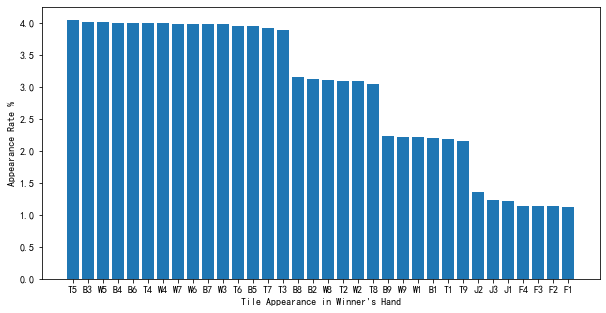

In [16]:
dists = list(final_tile_count_appearance_cp.keys())
values = list(final_tile_count_appearance_cp.values())
fig, ax = plt.subplots()
bars = ax.bar(dists, values, tick_label=dists)
# ax.bar_label(bars)
# plt.bar(dists, values, tick_label=dists, label=values)
# print(winner_relative_init_pos_polar)
plt.xlabel("Tile Appearance in Winner's Hand")
plt.ylabel("Appearance Rate %")
plt.show()

In [17]:
final_tile_count_occurence_cp = copy.deepcopy(final_tile_count_occurence)
del final_tile_count_occurence_cp['AnGang']
final_tile_count_occurence_cp = dict(sorted(final_tile_count_occurence_cp.items(),key=lambda x:x[1],reverse=True))
sum_of_tiles=0
for t in final_tile_count_occurence_cp:
    sum_of_tiles+=final_tile_count_occurence_cp[t]
for t in final_tile_count_occurence_cp:
    final_tile_count_occurence_cp[t] = 100.0*final_tile_count_occurence_cp[t]/sum_of_tiles

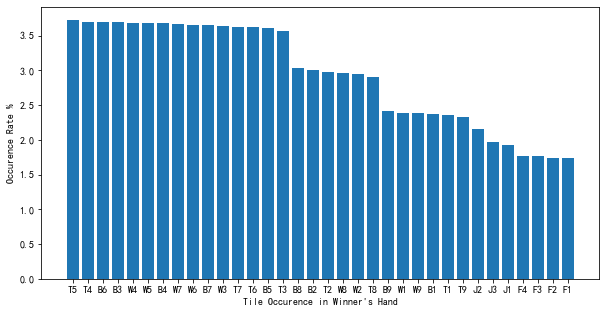

In [19]:
dists = list(final_tile_count_occurence_cp.keys())
values = list(final_tile_count_occurence_cp.values())
fig, ax = plt.subplots()
bars = ax.bar(dists, values, tick_label=dists)
# ax.bar_label(bars)
# plt.bar(dists, values, tick_label=dists, label=values)
# print(winner_relative_init_pos_polar)
plt.xlabel("Tile Occurence in Winner's Hand")
plt.ylabel("Occurence Rate %")
plt.show()

In [23]:
combined_count_occurence = defaultdict(default_value)
for t in final_tile_count_occurence_cp:
    if t[0] in ['B',"W",'T']:
        combined_tile = "X"+t[1]
        combined_count_occurence[combined_tile]+=final_tile_count_occurence_cp[t]
    else:
        combined_count_occurence[t]+=final_tile_count_occurence_cp[t]
combined_count_appearance = defaultdict(default_value)
for t in final_tile_count_appearance_cp:
    if t[0] in ['B',"W",'T']:
        combined_tile = "X"+t[1]
        combined_count_appearance[combined_tile]+=final_tile_count_appearance_cp[t]
    else:
        combined_count_appearance[t]+=final_tile_count_appearance_cp[t]
combined_count_occurence = dict(sorted(combined_count_occurence.items(),key=lambda x:x[1],reverse=True))
combined_count_appearance = dict(sorted(combined_count_appearance.items(),key=lambda x:x[1],reverse=True))

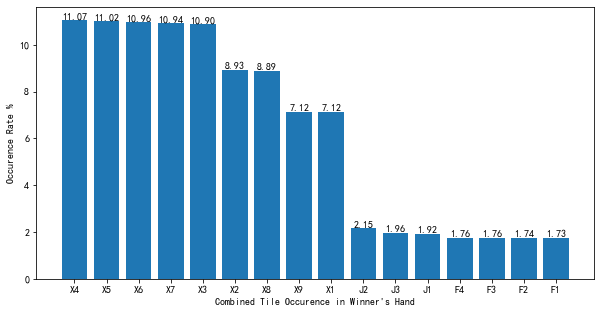

In [24]:
dists = list(combined_count_occurence.keys())
values = list(combined_count_occurence.values())
fig, ax = plt.subplots()
bars = ax.bar(dists, values, tick_label=dists)
ax.bar_label(bars, fmt="%.2f")
# plt.bar(dists, values, tick_label=dists, label=values)
# print(winner_relative_init_pos_polar)
plt.xlabel("Combined Tile Occurence in Winner's Hand")
plt.ylabel("Occurence Rate %")
plt.show()

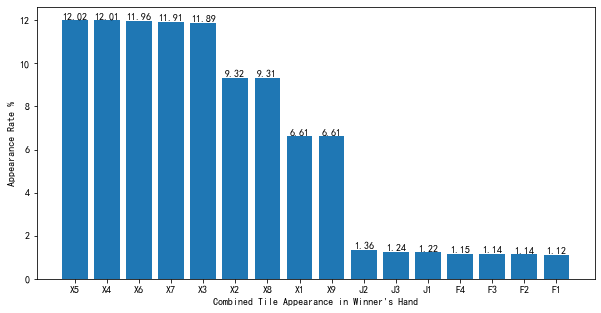

In [25]:
dists = list(combined_count_appearance.keys())
values = list(combined_count_appearance.values())
fig, ax = plt.subplots()
bars = ax.bar(dists, values, tick_label=dists)
ax.bar_label(bars, fmt="%.2f")
# plt.bar(dists, values, tick_label=dists, label=values)
# print(winner_relative_init_pos_polar)
plt.xlabel("Combined Tile Appearance in Winner's Hand")
plt.ylabel("Appearance Rate %")
plt.show()